In [14]:
%load_ext autoreload
%autoreload 2

import jax
import jax.random as random
import jax.numpy as jnp

import ott
from ott.tools import transport

from target_new import *

print(f"JAX backend: {jax.default_backend()}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
JAX backend: cpu


In [3]:
key = random.PRNGKey(123)
key, subk = random.split(key)
data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er")

In [20]:
data.passed_key

array([3107446009, 3736104797], dtype=uint32)

In [6]:
data.x.shape

(100, 20)

In [22]:
data.theta

[DeviceArray([[-2.2579439 ,  1.6911914 ,  1.1334798 , -1.4311824 ,
               -1.017936  , -1.7722476 ,  2.140372  ,  1.5610131 ,
               -0.5072684 ,  1.1757507 , -1.9499156 , -1.4106574 ,
                1.5665686 ,  0.5304006 ,  1.1757998 , -0.7402674 ,
                1.3065236 , -1.4984069 ,  1.9828898 , -0.7646949 ],
              [ 0.6898995 , -0.7492544 , -1.0303404 , -1.0967577 ,
                0.8316336 ,  1.8737067 ,  2.1323917 ,  0.6426575 ,
                0.6346039 , -0.80355775, -1.0423875 , -0.5373684 ,
                0.7894646 , -1.2072649 , -1.1243123 ,  0.5920304 ,
                0.74477166,  2.0853415 ,  0.9286977 ,  0.98807484],
              [ 0.6708227 ,  1.9507419 ,  1.3081424 , -0.6589951 ,
               -0.6815443 ,  1.1576409 ,  2.2307644 , -1.225159  ,
               -0.80150014, -1.3127525 ,  2.6633165 ,  0.53212917,
               -2.1047983 , -1.0286772 ,  1.2532508 ,  0.7558065 ,
                1.7866722 ,  2.126708  , -2.0080996 , -1.640

In [13]:
#dir(data)

In [9]:
#Sampling of 100 samples with the new procedure, for 2 time points
n_timepoints = 2
observations = []
for timepoint in range(n_timepoints):
    key = random.PRNGKey((timepoint+1)*100)
    key, subk = random.split(key)
    data, model = make_linear_gaussian_model(key=subk, n_vars=20, graph_prior_str="er")
    observations.append(data.x)
observations

[DeviceArray([[ 0.6520717 ,  1.5505279 ,  1.9929451 , ...,  0.40720022,
                0.46255994,  1.0611591 ],
              [ 0.25167984, -0.19690266, -0.2800779 , ...,  0.19163465,
               -0.08968908,  0.5379255 ],
              [-0.9097376 ,  0.79295933, -0.7557866 , ...,  0.06335   ,
               -0.20144786,  0.84863126],
              ...,
              [-0.32471505, -0.46590245, -0.96749103, ..., -0.2747648 ,
               -0.3105419 , -0.28192112],
              [ 0.207169  ,  0.39963812,  0.41005224, ...,  0.18883942,
                0.06590334, -0.2367214 ],
              [ 1.7747438 , -0.36859536,  0.22505425, ...,  0.43051255,
               -0.25627318,  0.43956342]], dtype=float32),
 DeviceArray([[ 0.375929  ,  0.04333784,  0.58702564, ...,  1.0094118 ,
               -0.13518336,  0.21687153],
              [-4.1781907 , -0.81362134, -1.7559614 , ..., -0.7287859 ,
               -0.36845523, -1.1895245 ],
              [ 3.9204707 ,  1.0706784 , -0.5963004 

### Try an optimal transport example:

In [11]:
# Samples two point clouds and their weights.
### For our synthetic data calculate the transport matrix
rngs = jax.random.split(jax.random.PRNGKey(0),2)
x1 = observations[0]
x2 = observations[1]
a = jax.random.uniform(rngs[0], (100,))
b = jax.random.uniform(rngs[1], (100,))
a, b = a / jnp.sum(a), b / jnp.sum(b)

# Computes the couplings via Sinkhorn algorithm.
ot = transport.solve(x1, x2, a=a, b=b)
# For adjacent time points we want to calculate the transport matrix (transport map) πti,ti+1
P = ot.matrix

In [17]:
import matplotlib.pyplot as plt

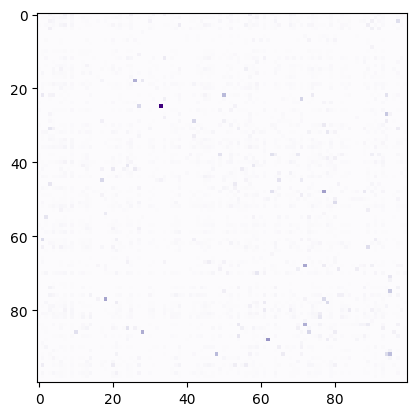

In [18]:
plt.imshow(P, cmap="Purples")

In [12]:
P.shape # this matrix contains the couplings between the points

(100, 100)

The optimization problem that we want to solve is the following: 
$$\min_{i,j} \pi_{ij}c_{ij} \quad 

\text{s.t} \quad \pi \mathbb{1} = \alpha \quad  \text{and} \quad \pi^T \mathbb{1} = b $$


I could also use more advanced tools for calculating $\Pi$. See [here](https://ott-jax.readthedocs.io/en/stable/_autosummary/ott.core.sinkhorn.sinkhorn.html)